In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


In [2]:
file_path = 'tesla-stock-price.csv'
data = pd.read_csv(file_path)

In [3]:
print(data.head())

         date   close         volume    open    high       low
0       11:34  270.49      4,787,699  264.50  273.88  262.2400
1  2018/10/15  259.59   6189026.0000  259.06  263.28  254.5367
2  2018/10/12  258.78   7189257.0000  261.00  261.99  252.0100
3  2018/10/11  252.23   8128184.0000  257.53  262.25  249.0300
4  2018/10/10  256.88  12781560.0000  264.61  265.51  247.7700


In [4]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 757 entries, 0 to 756
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    757 non-null    object 
 1   close   757 non-null    float64
 2   volume  757 non-null    object 
 3   open    757 non-null    float64
 4   high    757 non-null    float64
 5   low     757 non-null    float64
dtypes: float64(4), object(2)
memory usage: 35.6+ KB
None
            close        open        high         low
count  757.000000  757.000000  757.000000  757.000000
mean   272.645614  272.760659  277.122776  268.017399
std     58.378585   58.449827   59.194761   57.515736
min    143.670000  142.320000  154.970000  141.050000
25%    219.560000  219.640000  222.569000  216.080000
50%    277.450000  277.625000  280.789900  273.550000
75%    322.690000  321.560000  327.120000  316.560100
max    385.000000  386.690000  389.610000  379.345000


In [5]:
# Convert date column to datetime if present
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

In [6]:
close_prices = data['close'].values.reshape(-1, 1)

In [7]:
# Scale data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

In [8]:
# Split data into training and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


In [9]:
# Here we write the function for lstm dataset
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [10]:
X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

In [11]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [16]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))


In [17]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [18]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.1674 - val_loss: 0.0058
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0203 - val_loss: 0.0149
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0130 - val_loss: 0.0066
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0106 - val_loss: 0.0046
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0077 - val_loss: 0.0044
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0075 - val_loss: 0.0043
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0081 - val_loss: 0.0042
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0079 - val_loss: 0.0041
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0078 - val_loss: 0.0041
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0077 - val_loss: 0.0039
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0068 - val_loss: 0.0039
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

In [19]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


In [21]:
# here we inverse transform predictions and actual data
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [22]:
train_index = data.index[60:train_size - 1]  # Adjusted for y_train length
test_index = data.index[train_size + 60 + 1:]  # test starts after train size + 60 timesteps

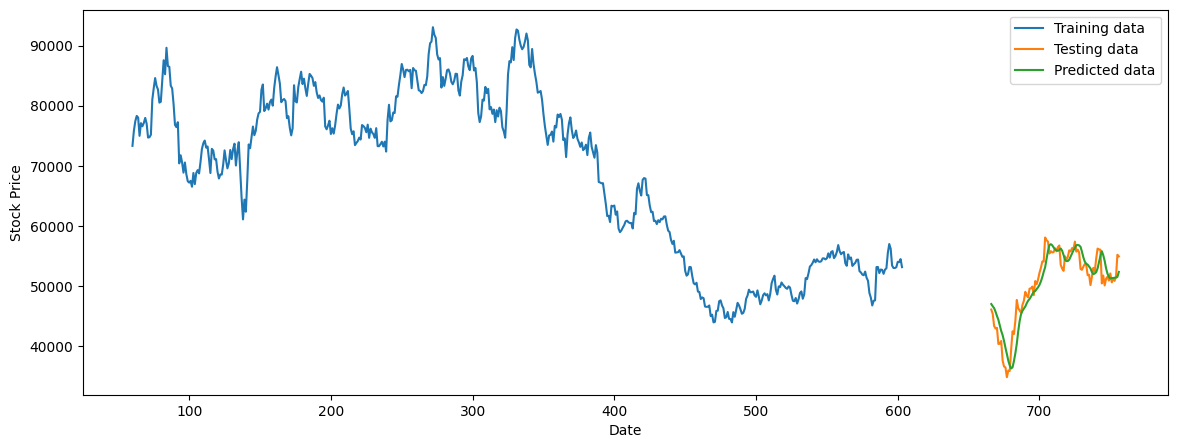

In [23]:
plt.figure(figsize=(14, 5))
plt.plot(train_index, y_train, label='Training data')  # Adjusting the index range
plt.plot(test_index, y_test, label='Testing data')  # Adjusting the index range
plt.plot(test_index, test_predict, label='Predicted data')  # Predicted values on test data
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
